In [1]:
import cv2
import os
from tensorflow import keras

import tensorflow as tf 
import matplotlib.pyplot as plt

data_path = 'mednist_images'
plt.style.use('seaborn-white')

In [3]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


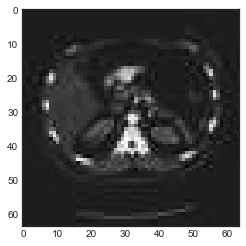

In [6]:
img_test = cv2.imread('mednist_images/AbdomenCT/000000.jpeg',0)
plt.imshow(img_test,cmap='gray')

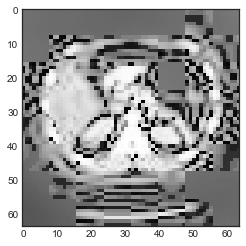

In [6]:
from skimage.morphology import disk
from skimage.filters import rank
footprint = disk(50)
img_eq = rank.equalize(img_test, footprint=footprint)
plt.imshow(img_eq,cmap='gray')

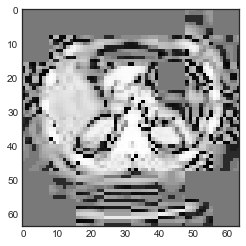

In [7]:
from skimage import exposure
img_rescale = exposure.equalize_hist(img_test)
plt.imshow(img_rescale,cmap='gray')

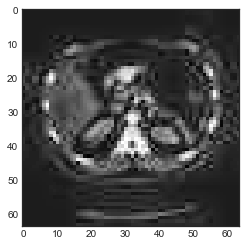

In [8]:
img_adapteq = exposure.equalize_adapthist(img_test, clip_limit=0.03)
plt.imshow(img_adapteq,cmap='gray')

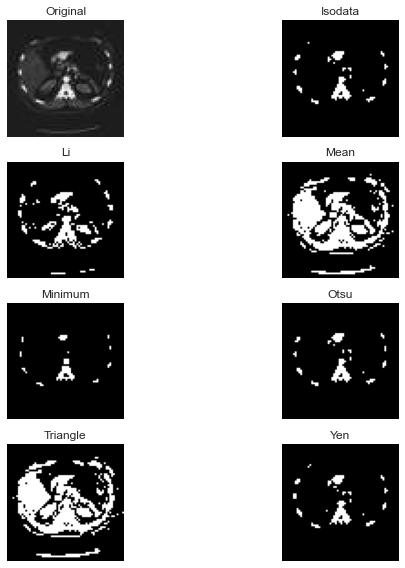

In [11]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(img_test, figsize=(10, 8), verbose=False)
plt.show()

In [2]:
BATCH_SIZE =32
IMG_SIZE = (64, 64)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels='inferred',
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset= "training",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)
                                                            
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels='inferred',
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset= "validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 58954 files belonging to 6 classes.
Using 41268 files for training.
Found 58954 files belonging to 6 classes.
Using 17686 files for validation.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
# val_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))

In [49]:
image_batch,label_batch = next(iter(val_ds))

image_batch

TensorShape([32, 64, 64, 1])

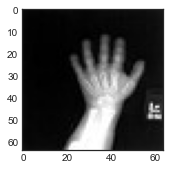

In [93]:
plt.imshow(image_batch[20],cmap='gray')


In [4]:
from tensorflow.keras import layers

def get_model_pseudoxcept(img_size):
    inputs = tf.keras.Input(shape=img_size + (1,))

    # x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  


    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)

        x = layers.add([x, residual])
    
        previous_block_activation = x 

    # x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.GlobalMaxPool2D()(x)
    # x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(6, activation='softmax')(x)
    outputs = x

    model = tf.keras.Model(inputs, outputs)
    return model

tf.keras.backend.clear_session()

In [5]:
model_xcept = get_model_pseudoxcept((64,64))


In [6]:
model_xcept.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [8]:
scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",mode="min",factor=0.5,patience=3, min_lr=0.00000001)

model_xcept.compile(
    optimizer="Adamax",
    loss="sparse_categorical_crossentropy",
    # loss=scce
    metrics=["accuracy"]
      )



In [9]:
history = model_xcept.fit(
    train_dataset,
    callbacks=[reduce_lr],
    epochs=100,
    validation_data=validation_dataset,
    steps_per_epoch=100,
    validation_steps=10
    )

Epoch 1/100
100/100 [==============================] - 5s 13ms/step - loss: 0.8109 - accuracy: 0.8234 - val_loss: 1.7786 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.1334 - accuracy: 0.9622 - val_loss: 1.6308 - val_accuracy: 0.3094 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 13ms/step - loss: 0.1000 - accuracy: 0.9694 - val_loss: 1.3464 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0556 - accuracy: 0.9869 - val_loss: 0.9665 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0442 - accuracy: 0.9891 - val_loss: 0.2476 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0301 - accuracy: 0.9894 - val_loss: 0.0203 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 

In [118]:
 model_xcept.evaluate(validation_dataset)

70/70 [==============================] - 3s 34ms/step - loss: 9.3604e-04 - accuracy: 0.9998


[0.0009360437979921699, 0.9998303651809692]

In [23]:
# model_xcept.save('./my_models/xcept_style_01_accuracy9998.h5')

model_xcept =tf.keras.models.load_model('./my_models/xcept_style_01_accuracy9998.h5')

In [24]:
images, labels = list(zip(*validation_dataset))



In [182]:
labels

(<tf.Tensor: shape=(256,), dtype=int32, numpy=
 array([2, 1, 4, 3, 1, 3, 5, 1, 5, 4, 5, 5, 3, 5, 1, 5, 2, 4, 2, 3, 2, 0,
        2, 1, 2, 2, 3, 1, 5, 5, 0, 4, 0, 1, 4, 0, 4, 5, 0, 4, 2, 5, 0, 4,
        5, 3, 2, 1, 4, 2, 0, 3, 4, 3, 4, 1, 2, 1, 3, 2, 1, 3, 2, 0, 4, 4,
        3, 3, 5, 3, 3, 2, 2, 5, 0, 1, 1, 1, 4, 0, 3, 5, 0, 3, 2, 5, 5, 5,
        1, 4, 5, 1, 1, 3, 5, 3, 2, 0, 0, 3, 0, 1, 2, 3, 4, 5, 1, 0, 0, 0,
        5, 4, 1, 0, 4, 4, 0, 0, 5, 4, 3, 3, 2, 5, 2, 2, 3, 2, 0, 1, 3, 5,
        3, 5, 1, 2, 3, 5, 5, 2, 3, 5, 4, 4, 1, 3, 4, 2, 0, 0, 5, 0, 3, 5,
        5, 5, 4, 3, 4, 4, 1, 5, 3, 0, 5, 3, 2, 4, 0, 4, 5, 2, 5, 1, 0, 2,
        4, 4, 5, 5, 2, 0, 1, 4, 4, 0, 5, 3, 4, 0, 4, 1, 2, 1, 2, 2, 4, 2,
        4, 3, 3, 0, 3, 3, 2, 1, 2, 5, 1, 3, 2, 3, 3, 4, 1, 1, 1, 1, 0, 4,
        2, 2, 3, 3, 4, 2, 1, 5, 4, 4, 4, 5, 4, 0, 2, 3, 5, 2, 0, 3, 2, 3,
        1, 1, 4, 0, 3, 0, 0, 3, 3, 2, 3, 0, 0, 3])>,
 <tf.Tensor: shape=(256,), dtype=int32, numpy=
 array([0, 1, 1, 4, 3, 2, 5, 2, 1, 5, 2

In [140]:
import numpy as np
type(labels



tuple

In [25]:
all_data = [(x[0].numpy(),x[1].numpy()) for x in list(validation_dataset)]

labels = np.hstack([x[1] for x in all_data ])
images = np.vstack([x[0] for x in all_data ])

# labels = np.hstack([(x[0].numpy(),x[1].numpy()) for x in list(validation_dataset)])
# images = np.vstack([x[0].numpy() for x in list(validation_dataset)])

In [186]:
labels.shape

(17686,)

In [189]:
images.shape

(17686, 64, 64, 1)

In [129]:
y_pred.shape

(17686, 6)

In [26]:
y_pred=model_xcept.predict(images)
con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.argmax(y_pred,-1))

553/553 [==============================] - 4s 2ms/step


In [27]:
con_mat

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[3017,    0,    0,    0,    0,    0],
       [   0, 2689,    0,    0,    0,    0],
       [   0,    0, 3117,    0,    0,    0],
       [   0,    0,    0, 2939,    0,    0],
       [   0,    1,    1,    0, 2968,    1],
       [   0,    0,    0,    0,    0, 2953]])>

In [193]:
np.argmax(y_pred,-1)!=labels

array([False, False, False, ..., False, False, False])

In [28]:
idx_wrong = np.argwhere(np.argmax(y_pred,-1)!=labels)[:,0]
class_names = os.listdir(data_path)
idx_wrong

array([ 4326,  7995, 10404], dtype=int64)

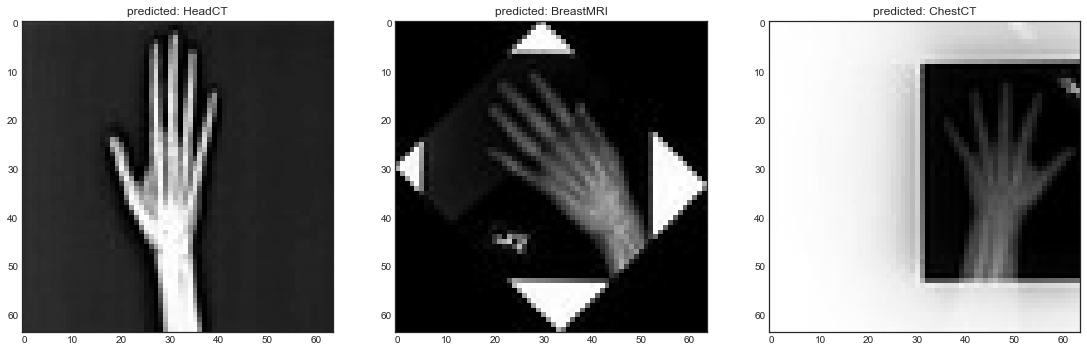

In [218]:
plt.figure(figsize=(15,8))
i=0
for idx in idx_wrong:
    i+=1
    plt.subplot(1,len(idx_wrong),i)
    plt.imshow(images[idx],cmap='gray')
    plt.title(f'predicted: {class_names[np.argmax(y_pred,-1)[idx]]}')

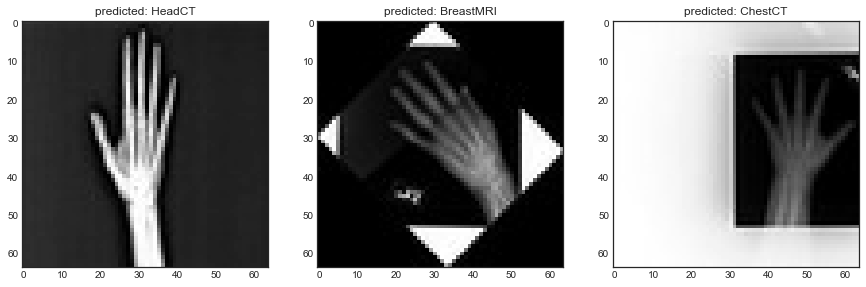

In [29]:
# import numpy as np
# idx_wrong = np.array([ 6954, 10196, 11136])

plt.figure(figsize=(15,8))
i=0
for idx in idx_wrong:
    i+=1
    plt.subplot(1,len(idx_wrong),i)
    plt.imshow(images[idx],cmap='gray')
    plt.title(f'predicted: {class_names[np.argmax(y_pred,-1)[idx]]}')

In [ ]:
pip install innvestigate

In [ ]:
import innvestigate